# **Progetto ai 2**

In [ ]:
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost

In [ ]:
# Librerie per manipolazione dati
import pandas as pd
import numpy as np

# Librerie per visualizzazione
import matplotlib.pyplot as plt
import seaborn as sns

# Librerie per preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils.class_weight import compute_class_weight

# Modelli di classificazione che confronteremo
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

# Metriche per la valutazione
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve
)


# Fissiamo il seed per garantire la riproducibilita dei risultati

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
#carichiamo i dati
df = pd.read_csv('../var/AIDS_ClinicalTrial_GroupStudy175.csv')

In [ ]:

#Dizionario delle variabili

print("""
Dizionario delle Variabili
==========================

Demografiche:
  - age      : Eta del paziente (anni)
  - wtkg     : Peso (kg)
  - gender   : Sesso (0=Femmina, 1=Maschio)
  - race     : Etnia (0=non-bianco, 1=bianco)

Fattori di rischio:
  - hemo     : Emofilia (0=no, 1=si)
  - homo     : Comportamento omosessuale (0=no, 1=si)
  - drugs    : Uso di droghe per via endovenosa (0=no, 1=si)

Variabili cliniche al baseline:
  - karnof   : Karnofsky Performance Score (70-100)
  - cd40     : Conta CD4 al baseline (cellule/mm3)
  - cd80     : Conta CD8 al baseline (cellule/mm3)
  - symptom  : Sintomi AIDS-correlati (0=asintomatico, 1=sintomatico)

Storia terapeutica:
  - preanti  : Giorni di terapia antiretrovirale prima dello studio
  - oprior   : Terapia non-ZDV precedente (0=no, 1=si)
  - z30      : ZDV nei 30 giorni precedenti (0=no, 1=si)
  - str2     : Storia antiretrovirale (0=naive, 1=experienced)
  - strat    : Stratificazione (1=naive, 2=1-52 settimane, 3=>52 settimane)

Trattamento:
  - trt      : Braccio di trattamento (0=ZDV, 1=ZDV+ddI, 2=ZDV+ddC, 3=ddI)
  - treat    : Tipo di terapia (0=monoterapia, 1=combinata)
  - offtrt   : Uscito dal trattamento prima delle 96 settimane (0=no, 1=si)

Follow-up a 20 settimane:
  - cd420    : Conta CD4 a 20 settimane (cellule/mm3)
  - cd820    : Conta CD8 a 20 settimane (cellule/mm3)

Target:
  - label    : Evento osservato (0=censurato, 1=evento)
""")


Dizionario delle Variabili

Demografiche:
  - age      : Eta del paziente (anni)
  - wtkg     : Peso (kg)
  - gender   : Sesso (0=Femmina, 1=Maschio)
  - race     : Etnia (0=non-bianco, 1=bianco)

Fattori di rischio:
  - hemo     : Emofilia (0=no, 1=si)
  - homo     : Comportamento omosessuale (0=no, 1=si)
  - drugs    : Uso di droghe per via endovenosa (0=no, 1=si)

Variabili cliniche al baseline:
  - karnof   : Karnofsky Performance Score (70-100)
  - cd40     : Conta CD4 al baseline (cellule/mm3)
  - cd80     : Conta CD8 al baseline (cellule/mm3)
  - symptom  : Sintomi AIDS-correlati (0=asintomatico, 1=sintomatico)

Storia terapeutica:
  - preanti  : Giorni di terapia antiretrovirale prima dello studio
  - oprior   : Terapia non-ZDV precedente (0=no, 1=si)
  - z30      : ZDV nei 30 giorni precedenti (0=no, 1=si)
  - str2     : Storia antiretrovirale (0=naive, 1=experienced)
  - strat    : Stratificazione (1=naive, 2=1-52 settimane, 3=>52 settimane)

Trattamento:
  - trt      : Brac

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2139 entries, 0 to 2138
Data columns (total 24 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   time     2139 non-null   int64  
 1   trt      2139 non-null   int64  
 2   age      2139 non-null   int64  
 3   wtkg     2139 non-null   float64
 4   hemo     2139 non-null   int64  
 5   homo     2139 non-null   int64  
 6   drugs    2139 non-null   int64  
 7   karnof   2139 non-null   int64  
 8   oprior   2139 non-null   int64  
 9   z30      2139 non-null   int64  
 10  zprior   2139 non-null   int64  
 11  preanti  2139 non-null   int64  
 12  race     2139 non-null   int64  
 13  gender   2139 non-null   int64  
 14  str2     2139 non-null   int64  
 15  strat    2139 non-null   int64  
 16  symptom  2139 non-null   int64  
 17  treat    2139 non-null   int64  
 18  offtrt   2139 non-null   int64  
 19  cd40     2139 non-null   int64  
 20  cd420    2139 non-null   int64  
 21  cd80     2139 

In [ ]:
print(df.head())

   time  trt  age     wtkg  hemo  homo  drugs  karnof  oprior  z30  ...  str2  \
0   948    2   48  89.8128     0     0      0     100       0    0  ...     0   
1  1002    3   61  49.4424     0     0      0      90       0    1  ...     1   
2   961    3   45  88.4520     0     1      1      90       0    1  ...     1   
3  1166    3   47  85.2768     0     1      0     100       0    1  ...     1   
4  1090    0   43  66.6792     0     1      0     100       0    1  ...     1   

   strat  symptom  treat  offtrt  cd40  cd420  cd80  cd820  label  
0      1        0      1       0   422    477   566    324      0  
1      3        0      1       0   162    218   392    564      1  
2      3        0      1       1   326    274  2063   1893      0  
3      3        0      1       0   287    394  1590    966      0  
4      3        0      0       0   504    353   870    782      0  

[5 rows x 24 columns]


In [ ]:

# Verifica valori mancanti, prima di procedere con l'analisi dobbiamo verificare se ci sono missing values

missing = df.isnull().sum()
print("\nVerifica valori mancanti:")
if missing.sum() == 0:
    print("Ottimo! Non ci sono valori mancanti nel dataset.")
else:
    print("Attenzione: sono presenti valori mancanti:")
    print(missing[missing > 0])


Verifica valori mancanti:
Ottimo! Non ci sono valori mancanti nel dataset.


In [ ]:

# Pulizia iniziale del dataset:
# Verifichiamo se ci sono colonne con varianza zero (costanti) perche non apporterebbero informazione ai modelli

print("\nVerifica colonne con varianza zero:")
cols_to_remove = []

for col in df.columns:
    n_unique = df[col].nunique()
    if n_unique == 1:
        print(f"  - '{col}' ha un solo valore unico: {df[col].unique()[0]}")
        cols_to_remove.append(col)

# Rimuoviamo anche 'time' perchè non è una feature predittiva ma piuttosto un'informazione sull'outcome
if 'time' in df.columns:
    cols_to_remove.append('time')

# Applichiamo la pulizia
df_clean = df.drop(columns=[c for c in cols_to_remove if c in df.columns], errors='ignore')

print(f"\nDataset dopo la pulizia: {df_clean.shape[0]} righe x {df_clean.shape[1]} colonne")
print(f"Colonne rimosse: {cols_to_remove if cols_to_remove else 'nessuna'}")


Verifica colonne con varianza zero:
  - 'zprior' ha un solo valore unico: 1

Dataset dopo la pulizia: 2139 righe x 22 colonne
Colonne rimosse: ['zprior', 'time']


# **Analisi esplorativa dei dati(EDA)**

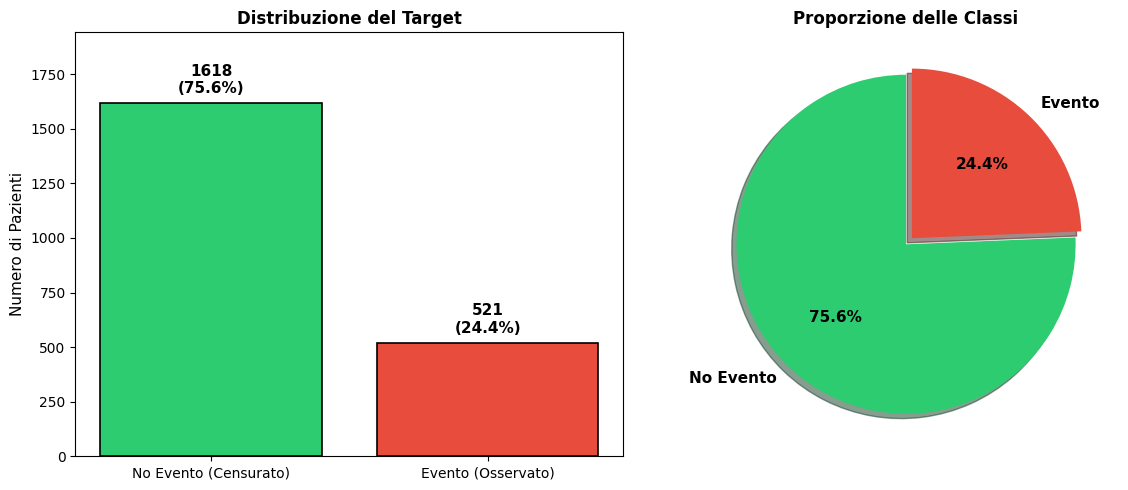


Rapporto di sbilanciamento: 3.11:1
Questo significa che per ogni paziente con evento, ci sono circa 3 pazienti senza evento.


In [ ]:

# Analisi della variabile target verifichiamo la distribuzione delle classi.


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

colors = ['#2ecc71', '#e74c3c']  # verde per no evento, rosso per evento
counts = df_clean['label'].value_counts().sort_index()

# Grafico a barre
bars = axes[0].bar(
    ['No Evento (Censurato)', 'Evento (Osservato)'],
    counts.values,
    color=colors,
    edgecolor='black',
    linewidth=1.2
)

# Aggiungiamo le etichette sopra le barre
for bar, count in zip(bars, counts.values):
    height = bar.get_height()
    axes[0].annotate(
        f'{count}\n({count/len(df_clean)*100:.1f}%)',
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 5),
        textcoords="offset points",
        ha='center',
        va='bottom',
        fontsize=11,
        fontweight='bold'
    )

axes[0].set_ylabel('Numero di Pazienti', fontsize=11)
axes[0].set_title('Distribuzione del Target', fontsize=12, fontweight='bold')
axes[0].set_ylim(0, max(counts.values) * 1.2)

# Grafico a torta
axes[1].pie(
    counts.values,
    labels=['No Evento', 'Evento'],
    colors=colors,
    autopct='%1.1f%%',
    startangle=90,
    explode=(0, 0.05),
    shadow=True,
    textprops={'fontsize': 11, 'fontweight': 'bold'}
)
axes[1].set_title('Proporzione delle Classi', fontsize=12, fontweight='bold')


plt.tight_layout()
plt.show()

# Calcoliamo il rapporto di sbilanciamento
imbalance_ratio = counts[0] / counts[1]
print(f"\nRapporto di sbilanciamento: {imbalance_ratio:.2f}:1")
print(f"Questo significa che per ogni paziente con evento, ci sono circa {imbalance_ratio:.0f} pazienti senza evento.")

/tmp/ipython-input-1876392388.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend(loc='upper right')


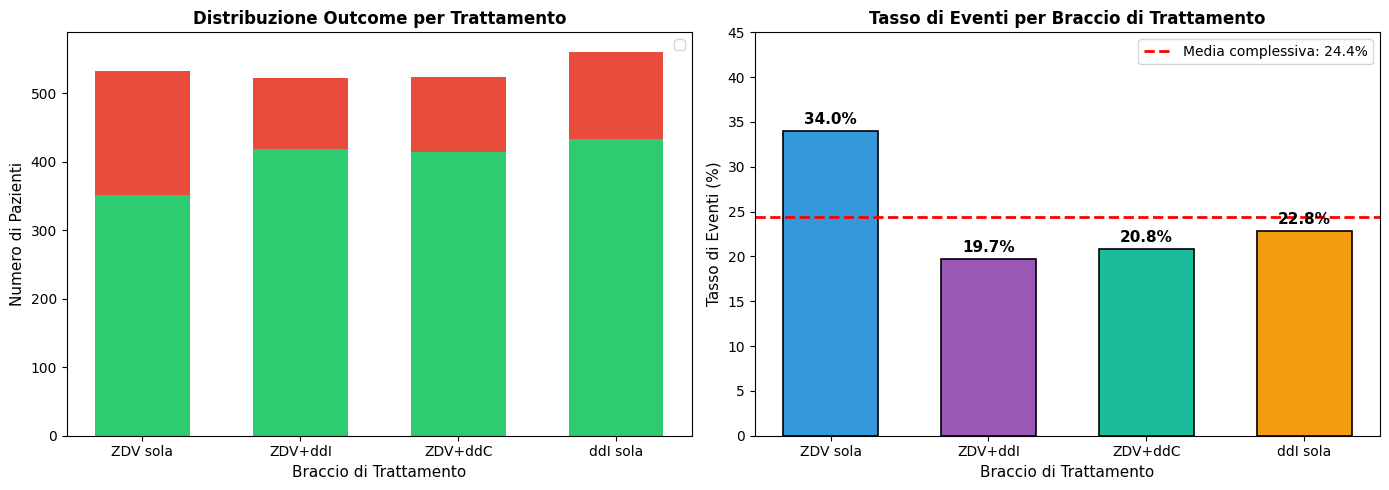


Osservazioni cliniche:
1. La monoterapia con ZDV ha il tasso di eventi piu' alto (34.0%)
2. Le terapie combinate mostrano tassi di eventi inferiori
3. Questi risultati sono coerenti con le conclusioni dello studio ACTG 175


In [ ]:

# Analisi dell'outcome per braccio di trattamento, è particolarmente interessante perche ci permette di verificare se i nostri dati sono coerenti con i risultati pubblicati nello studio originale del 1996.

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

trt_labels = ['ZDV sola', 'ZDV+ddI', 'ZDV+ddC', 'ddI sola']

# Calcoliamo le statistiche per ogni braccio di trattamento
trt_outcome = df_clean.groupby('trt')['label'].agg(['sum', 'count'])
trt_outcome['rate'] = trt_outcome['sum'] / trt_outcome['count'] * 100
trt_outcome['no_event'] = trt_outcome['count'] - trt_outcome['sum']

# Grafico a barre impilate
x = np.arange(4)
width = 0.6

bars1 = axes[0].bar(x, trt_outcome['no_event'], width, color='#2ecc71')
bars2 = axes[0].bar(x, trt_outcome['sum'], width, bottom=trt_outcome['no_event'],color='#e74c3c')

axes[0].set_xlabel('Braccio di Trattamento', fontsize=11)
axes[0].set_ylabel('Numero di Pazienti', fontsize=11)
axes[0].set_title('Distribuzione Outcome per Trattamento', fontsize=12, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(trt_labels, fontsize=10)
axes[0].legend(loc='upper right')

# Grafico del tasso di eventi per trattamento
treatment_colors = ['#3498db', '#9b59b6', '#1abc9c', '#f39c12']
bars = axes[1].bar(
    x, trt_outcome['rate'], width,
    color=treatment_colors,
    edgecolor='black',
    linewidth=1.2
)

# Aggiungiamo la linea della media
mean_rate = df_clean['label'].mean() * 100
axes[1].axhline(
    y=mean_rate,
    color='red',
    linestyle='--',
    linewidth=2,
    label=f'Media complessiva: {mean_rate:.1f}%'
)

# Etichette sopra le barre
for bar, rate in zip(bars, trt_outcome['rate']):
    axes[1].annotate(
        f'{rate:.1f}%',
        xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
        xytext=(0, 5),
        textcoords="offset points",
        ha='center',
        fontsize=11,
        fontweight='bold'
    )

axes[1].set_xlabel('Braccio di Trattamento', fontsize=11)
axes[1].set_ylabel('Tasso di Eventi (%)', fontsize=11)
axes[1].set_title('Tasso di Eventi per Braccio di Trattamento', fontsize=12, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(trt_labels, fontsize=10)
axes[1].set_ylim(0, 45)
axes[1].legend()

plt.tight_layout()
plt.show()

# Commento sui risultati
print("\nOsservazioni cliniche:")
print(f"La monoterapia con ZDV ha il tasso di eventi piu' alto ({trt_outcome['rate'].iloc[0]:.1f}%)")


In [ ]:

# Statistiche descrittive per le variabili continue

continuous_vars = ['age', 'wtkg', 'preanti', 'cd40', 'cd420', 'cd80', 'cd820']

print("\nStatistiche Descrittive - Variabili Continue")
print(df_clean[continuous_vars].describe().round(2).to_string())


Statistiche Descrittive - Variabili Continue
           age     wtkg  preanti     cd40    cd420     cd80    cd820
count  2139.00  2139.00  2139.00  2139.00  2139.00  2139.00  2139.00
mean     35.25    75.13   379.18   350.50   371.31   986.63   935.37
std       8.71    13.26   468.66   118.57   144.63   480.20   444.98
min      12.00    31.00     0.00     0.00    49.00    40.00   124.00
25%      29.00    66.68     0.00   263.50   269.00   654.00   631.50
50%      34.00    74.39   142.00   340.00   353.00   893.00   865.00
75%      40.00    82.56   739.50   423.00   460.00  1207.00  1146.50
max      70.00   159.94  2851.00  1199.00  1119.00  5011.00  6035.00


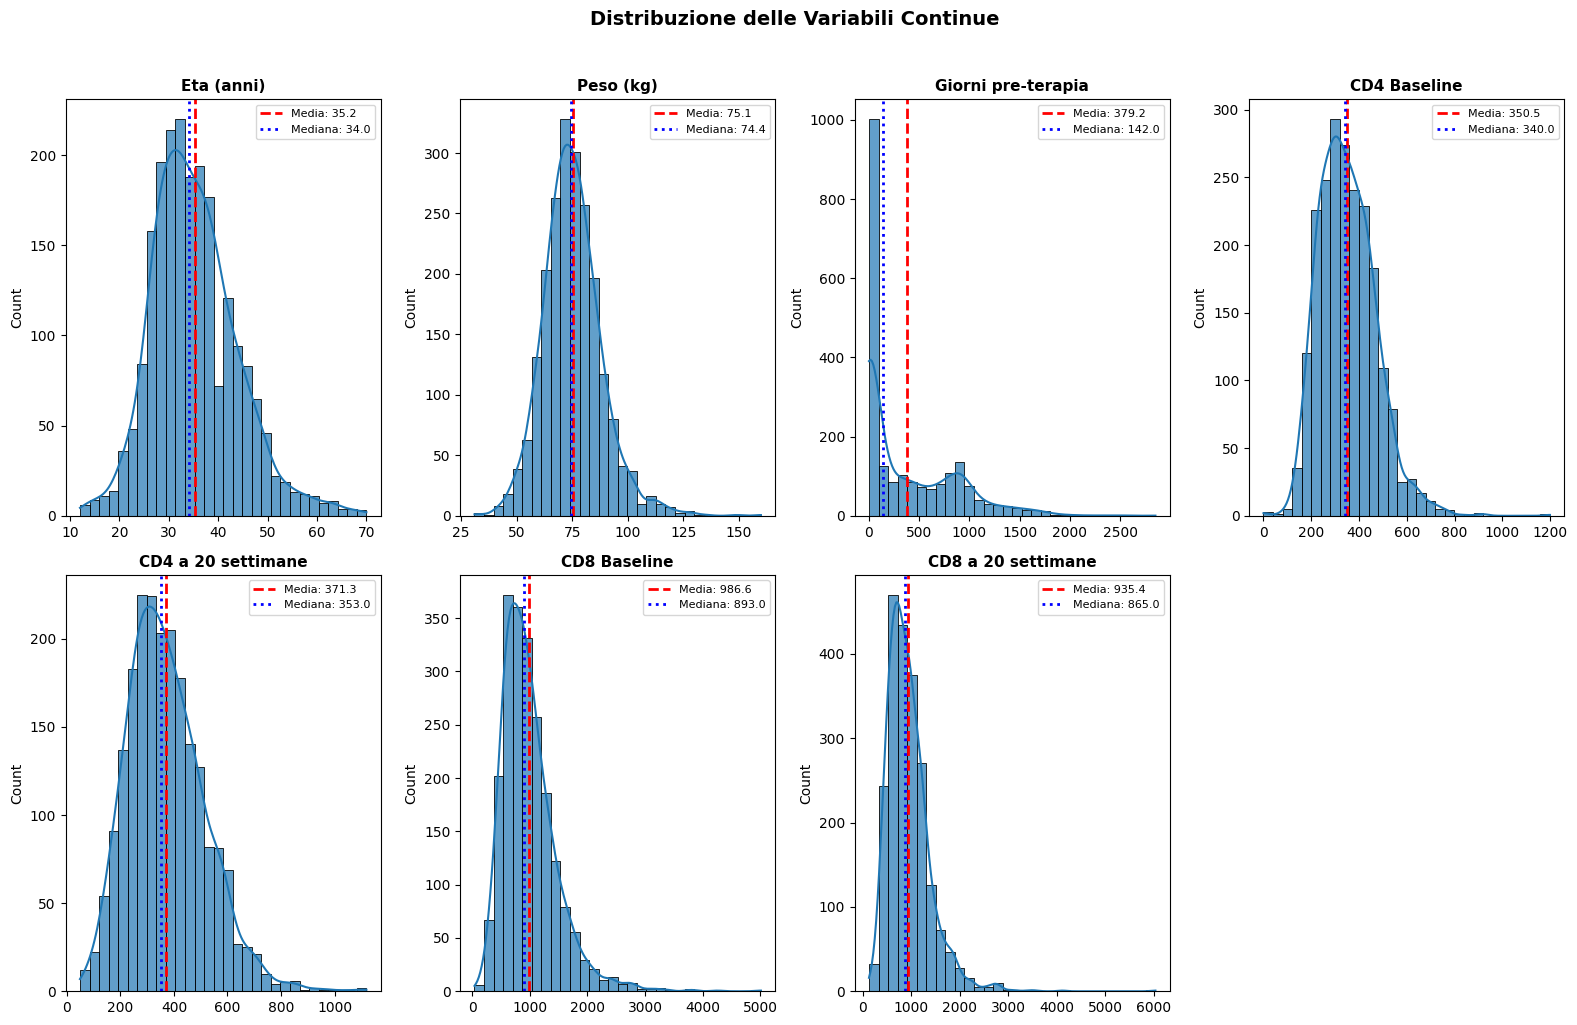

In [ ]:

# Distribuzione delle variabili continue


fig, axes = plt.subplots(2, 4, figsize=(16, 10))
axes = axes.flatten()

# Dizionario per titoli piu descrittivi
titles = {
    'age': 'Eta (anni)',
    'wtkg': 'Peso (kg)',
    'cd40': 'CD4 Baseline',
    'cd420': 'CD4 a 20 settimane',
    'cd80': 'CD8 Baseline',
    'cd820': 'CD8 a 20 settimane',
    'preanti': 'Giorni pre-terapia'
}

for i, col in enumerate(continuous_vars):
    ax = axes[i]

    # Istogramma con curva di densita
    sns.histplot(data=df_clean, x=col, kde=True, ax=ax, alpha=0.7, bins=30)

    # Linee per media e mediana
    mean_val = df_clean[col].mean()
    median_val = df_clean[col].median()
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Media: {mean_val:.1f}')
    ax.axvline(median_val, color='blue', linestyle=':', linewidth=2, label=f'Mediana: {median_val:.1f}')

    ax.set_title(titles.get(col, col), fontsize=11, fontweight='bold')
    ax.set_xlabel('')
    ax.legend(fontsize=8)

# Nascondiamo l'ultimo subplot vuoto
axes[7].axis('off')

plt.suptitle('Distribuzione delle Variabili Continue', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

/tmp/ipython-input-480857975.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(
/tmp/ipython-input-480857975.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(
/tmp/ipython-input-480857975.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(
/tmp/ipython-input-480857975.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(
/tmp/ipython-input-480857975.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() ha

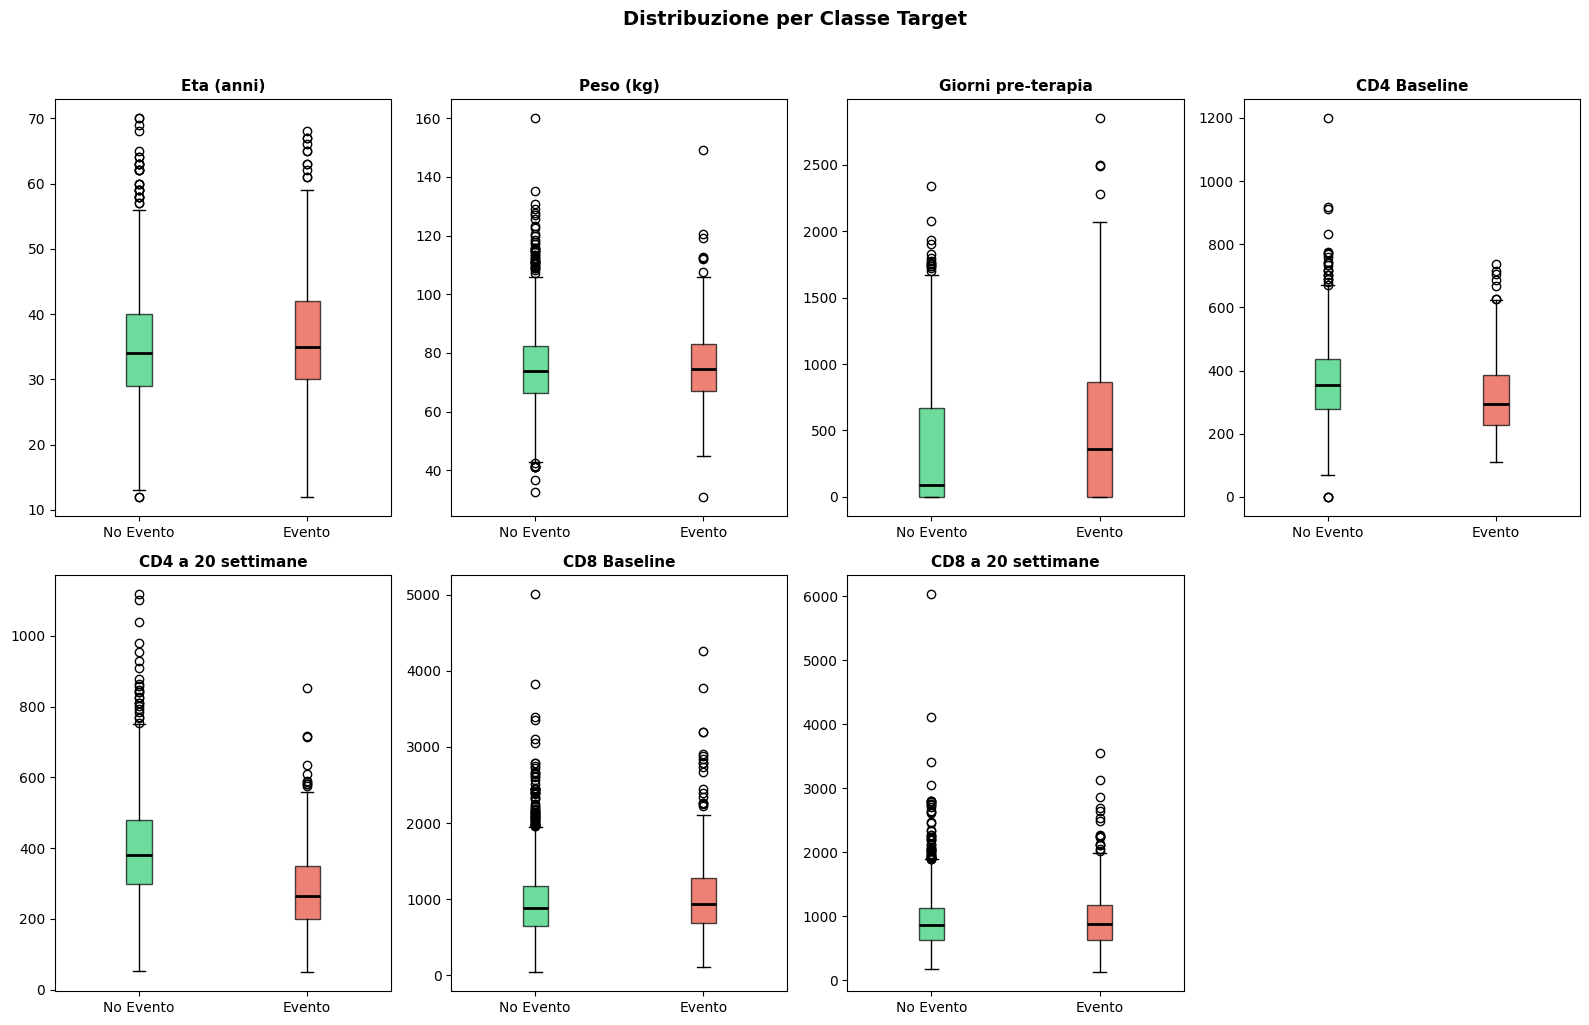

In [ ]:
# Confronto delle distribuzioni tra le due classi
# I boxplot ci permettono di visualizzare se ci sono differenze significative nelle variabili continue tra pazienti con e senza evento.

fig, axes = plt.subplots(2, 4, figsize=(16, 10))
axes = axes.flatten()

for i, col in enumerate(continuous_vars):
    ax = axes[i]

    bp = ax.boxplot(
        [df_clean[df_clean['label']==0][col], df_clean[df_clean['label']==1][col]],
        labels=['No Evento', 'Evento'],
        patch_artist=True
    )

    bp['boxes'][0].set_facecolor('#2ecc71')
    bp['boxes'][1].set_facecolor('#e74c3c')
    bp['boxes'][0].set_alpha(0.7)
    bp['boxes'][1].set_alpha(0.7)

    for median in bp['medians']:
        median.set_color('black')
        median.set_linewidth(2)

    ax.set_title(titles.get(col, col), fontsize=11, fontweight='bold')

axes[7].axis('off')

plt.suptitle('Distribuzione per Classe Target', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

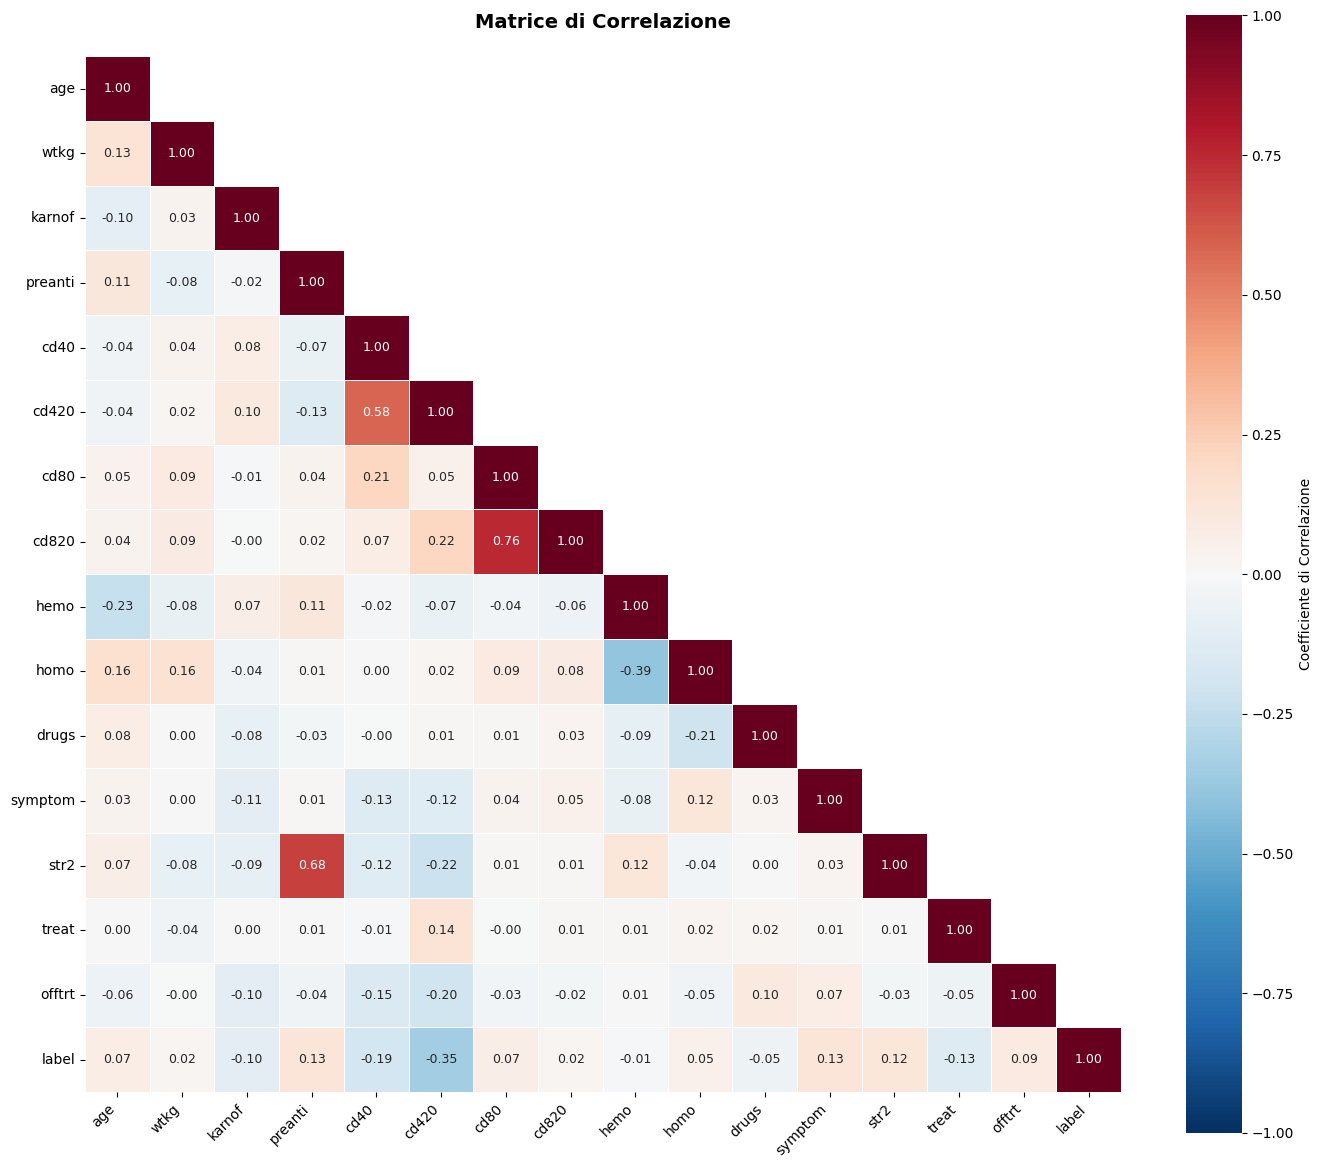

In [ ]:
# La matrice di correlazione ci aiuta a identificare relazioni lineari tra le variabili e potenziali problemi di multicollinearita.

# Selezioniamo le colonne numeriche piu rilevanti
cols_for_corr = ['age', 'wtkg', 'karnof', 'preanti', 'cd40', 'cd420',
                 'cd80', 'cd820', 'hemo', 'homo', 'drugs', 'symptom',
                 'str2', 'treat', 'offtrt', 'label']

corr_matrix = df_clean[cols_for_corr].corr()

# Creiamo la heatmap
fig, ax = plt.subplots(figsize=(14, 12))

#Mostriamo solo la parte triangolare inferiore
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt='.2f',
    cmap='RdBu_r',
    center=0,
    square=True,
    linewidths=0.5,
    ax=ax,
    annot_kws={'size': 9},
    vmin=-1,
    vmax=1,
    cbar_kws={'label': 'Coefficiente di Correlazione'}
)

ax.set_title('Matrice di Correlazione', fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:

# Correlazioni con il target
# Analizziamo specificamente quali variabili sono piu correlate con il target

print("\nTop 10 Correlazioni con il Target (label)")

correlations = df_clean[cols_for_corr].corr()['label'].drop('label')
correlations = correlations.sort_values(key=abs, ascending=False)

for i, (feature, corr) in enumerate(correlations.head(10).items(), 1):
    direction = "(aumenta rischio)" if corr > 0 else "(diminuisce rischio)"
    print(f"{i:2}. {feature:<12}: {corr:+.3f}  {direction}")


Top 10 Correlazioni con il Target (label)
 1. cd420       : -0.346  (diminuisce rischio)
 2. cd40        : -0.186  (diminuisce rischio)
 3. treat       : -0.130  (diminuisce rischio)
 4. symptom     : +0.129  (aumenta rischio)
 5. preanti     : +0.128  (aumenta rischio)
 6. str2        : +0.123  (aumenta rischio)
 7. karnof      : -0.103  (diminuisce rischio)
 8. offtrt      : +0.093  (aumenta rischio)
 9. age         : +0.070  (aumenta rischio)
10. cd80        : +0.065  (aumenta rischio)


# **Preprocessing**

In [ ]:
# Classificazione delle variabili:
# Organizziamo le variabili in base al tipo di trasformazione necessaria

# Variabile target
TARGET = 'label'

# Variabili categoriche nominali (richiedono One-Hot Encoding)
# - trt: 4 categorie (0,1,2,3) -> trattamenti diversi, non ordinabili
# - strat: 3 categorie (1,2,3) -> stratificazione per storia terapeutica
CATEGORICAL_COLS = ['trt', 'strat']

# Variabili continue (richiedono Scaling)
# Queste hanno range molto diversi (es. age: 12-70, cd40: 0-1200)
# quindi lo scaling e necessario per i modelli sensibili alle scale
CONTINUOUS_COLS = ['age', 'wtkg', 'preanti', 'cd40', 'cd80', 'karnof', 'cd420', 'cd820']

# Variabili binarie (gia in formato 0/1, non richiedono trasformazioni)
BINARY_COLS = ['hemo', 'homo', 'drugs', 'oprior', 'z30', 'race',
               'gender', 'str2', 'symptom', 'treat', 'offtrt']

# Lista completa delle feature
FEATURE_COLS = CATEGORICAL_COLS + CONTINUOUS_COLS + BINARY_COLS

print("Classificazione delle Variabili")
print(f"Categoriche (One-Hot Encoding): {len(CATEGORICAL_COLS)}")
for col in CATEGORICAL_COLS:
    print(f"  - {col}: {df_clean[col].nunique()} categorie")
print(f"\nContinue (StandardScaler): {len(CONTINUOUS_COLS)}")
print(f"Binarie (nessuna trasformazione): {len(BINARY_COLS)}")

Classificazione delle Variabili
Categoriche (One-Hot Encoding): 2
  - trt: 4 categorie
  - strat: 3 categorie

Continue (StandardScaler): 8
Binarie (nessuna trasformazione): 11


In [ ]:
# Separazione x e y

x = df_clean[FEATURE_COLS].copy()
y = df_clean[TARGET].copy()

print("Dimensioni dei dati:")
print(f"  x (matrice delle feature): {x.shape}")
print(f"  y (vettore target): {y.shape}")
print(f"\nDistribuzione del target:")
print(f"  Classe 0 (No Evento): {(y==0).sum()} ({(y==0).mean()*100:.1f}%)")
print(f"  Classe 1 (Evento):    {(y==1).sum()} ({(y==1).mean()*100:.1f}%)")

Dimensioni dei dati:
  x (matrice delle feature): (2139, 21)
  y (vettore target): (2139,)

Distribuzione del target:
  Classe 0 (No Evento): 1618 (75.6%)
  Classe 1 (Evento):    521 (24.4%)


In [ ]:
#Usiamo uno split stratificato per mantenere le proporzioni delle classi, sia nel training set che nel test set.
#Questo èimportante in quanto il dataset è sbilanciato

x_train, x_test, y_train, y_test = train_test_split(
    x, y,
    test_size=0.2,              # 20% dei dati per il test
    random_state=RANDOM_STATE,  # Per la riproducibilita
    stratify=y                  # Mantiene le proporzioni delle classi
)

print("Risultato dello Split")

print(f"Training set: {x_train.shape[0]} campioni ({x_train.shape[0]/len(x)*100:.1f}%)")
print(f"Test set:     {x_test.shape[0]} campioni ({x_test.shape[0]/len(x)*100:.1f}%)")

print("\nVerifica della stratificazione:")
print(f"  Training - Classe 1: {(y_train==1).mean()*100:.2f}%")
print(f"  Test     - Classe 1: {(y_test==1).mean()*100:.2f}%")


Risultato dello Split
Training set: 1711 campioni (80.0%)
Test set:     428 campioni (20.0%)

Verifica della stratificazione:
  Training - Classe 1: 24.37%
  Test     - Classe 1: 24.30%


In [ ]:

# Configurazione del ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False), CATEGORICAL_COLS),
        ('num', StandardScaler(), CONTINUOUS_COLS),
        ('bin', 'passthrough', BINARY_COLS)
    ],
    remainder='drop'  # Ignora eventuali colonne non specificate
)


In [ ]:

#Applicazione del preprocessing

#Fit sul training set e trasformazione
x_train_processed = preprocessor.fit_transform(x_train)

#Trasformazione del test set (usa i parametri appresi dal training)
x_test_processed = preprocessor.transform(x_test)

#Recuperiamo i nomi delle feature dopo l'encoding, per l'interpretazione dei risultati
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(CATEGORICAL_COLS)
feature_names = list(ohe_feature_names) + CONTINUOUS_COLS + BINARY_COLS

print("Preprocessing completato")
print(f"x_train: {x_train_processed.shape}")
print(f"x_test:  {x_test_processed.shape}")
print(f"\nNumero di feature dopo One-Hot Encoding: {len(feature_names)}")
print(f"(da {len(FEATURE_COLS)} feature originali)")

Preprocessing completato
x_train: (1711, 24)
x_test:  (428, 24)

Numero di feature dopo One-Hot Encoding: 24
(da 21 feature originali)


In [ ]:
# Verifica della standardizzazione
# Controlliamo che le variabili continue abbiano effettivamente, media circa 0 e deviazione standard circa 1 nel training set

x_train_df = pd.DataFrame(x_train_processed, columns=feature_names)

print("Verifica Standardizzazione (Training Set)")

print(f"{'Variabile':<12} {'Media':>10} {'Std':>10}")

for col in CONTINUOUS_COLS:
    mean = x_train_df[col].mean()
    std = x_train_df[col].std()
    print(f"{col:<12} {mean:>10.4f} {std:>10.4f}")

Verifica Standardizzazione (Training Set)
Variabile         Media        Std
age             -0.0000     1.0003
wtkg             0.0000     1.0003
preanti         -0.0000     1.0003
cd40            -0.0000     1.0003
cd80            -0.0000     1.0003
karnof           0.0000     1.0003
cd420            0.0000     1.0003
cd820           -0.0000     1.0003


In [ ]:

# Calcolo dei Class Weights
# I class weights sono una tecnica per gestire lo sbilanciamento delle classi.
# Assegnamo un peso maggiore alla classe minoritaria, in modo che gli errori su quella classe "costino" di piu durante il training.

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# Calcoliamo anche il rapporto per XGBoost (scale_pos_weight), XGBoost usa un parametro diverso per gestire lo sbilanciamento
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

print("Class Weights Calcolati")
print(f"Classe 0 (No evento): {class_weight_dict[0]:.4f}")
print(f"Classe 1 (Evento):    {class_weight_dict[1]:.4f}")
print(f"\nRapporto: {class_weight_dict[1]/class_weight_dict[0]:.2f}")
print(f"scale_pos_weight (per XGBoost): {scale_pos_weight:.2f}")
print(f"\nGli errori sulla classe minoritaria peseranno circa {class_weight_dict[1]/class_weight_dict[0]:.1f}volte di piu'.")

Class Weights Calcolati
Classe 0 (No evento): 0.6611
Classe 1 (Evento):    2.0516

Rapporto: 3.10
scale_pos_weight (per XGBoost): 3.10

Gli errori sulla classe minoritaria peseranno circa 3.1volte di piu'.


# **Training dei modelli**

In [ ]:

# Definizione dei modelli
# Per ogni modello abbiamo scelto iperparametri ragionevoli.

models = {
    'Dummy (Baseline)': DummyClassifier(
        strategy='most_frequent',  # Predice sempre la classe piu comune
        random_state=RANDOM_STATE
    ),

    'Logistic Regression': LogisticRegression(
        C=1.0,
        penalty='l2',
        class_weight='balanced',
        max_iter=1000,
        random_state=RANDOM_STATE
    ),

    'Gaussian Naive Bayes': GaussianNB(),

    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=10,
        class_weight='balanced',
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),

    #A differenza del Random Forest (che usa bagging), XGBoost costruisce gli alberi in sequenza, dove ogni albero cerca di correggere gli errori dei precedenti.
    'XGBoost': XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        scale_pos_weight=scale_pos_weight,
        random_state=RANDOM_STATE,
        eval_metric='logloss',      # Metrica per la valutazione interna
    )
}



In [ ]:
#La cross-validation ci permette di stimare le performance in modo piu robusto rispetto a un singolo train/test split.
#Usiamo StratifiedKFold per mantenere le proporzioni delle classi in ogni fold.

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring_metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

#Dizionario per salvare i risultati
cv_results = {}


for name, model in models.items():
    print(f"\nTraining: {name}...", end=" ")

    cv_results[name] = {}

    for metric in scoring_metrics:
        scores = cross_val_score(
            model,
            x_train_processed,
            y_train,
            cv=cv,
            scoring=metric
        )
        cv_results[name][metric] = {
            'mean': scores.mean(),
            'std': scores.std()
        }

    f1_mean = cv_results[name]['f1']['mean']
    f1_std = cv_results[name]['f1']['std']
    print(f"F1-Score: {f1_mean:.4f} (+/- {f1_std:.4f})")

print("\nCross-validation completata.")


Training: Dummy (Baseline)... 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.p

F1-Score: 0.0000 (+/- 0.0000)

Training: Logistic Regression... F1-Score: 0.5066 (+/- 0.0183)

Training: Gaussian Naive Bayes... F1-Score: 0.4589 (+/- 0.0204)

Training: Random Forest... F1-Score: 0.4774 (+/- 0.0188)

Training: XGBoost... F1-Score: 0.4433 (+/- 0.0250)

Cross-validation completata.


In [ ]:
# Tabella riassuntiva della Cross-Validation

print("\nRisultati Cross-Validation (media +/- std)")


cv_df = pd.DataFrame()
for name in models.keys():
    row = {'Modello': name}
    for metric in scoring_metrics:
        mean = cv_results[name][metric]['mean']
        std = cv_results[name][metric]['std']
        row[metric.upper()] = f'{mean:.4f} (+/-{std:.4f})'
    cv_df = pd.concat([cv_df, pd.DataFrame([row])], ignore_index=True)

print(cv_df.to_string(index=False))


Risultati Cross-Validation (media +/- std)
             Modello           ACCURACY          PRECISION             RECALL                 F1            ROC_AUC
    Dummy (Baseline) 0.7563 (+/-0.0013) 0.0000 (+/-0.0000) 0.0000 (+/-0.0000) 0.0000 (+/-0.0000) 0.5000 (+/-0.0000)
 Logistic Regression 0.6727 (+/-0.0066) 0.4003 (+/-0.0102) 0.6907 (+/-0.0421) 0.5066 (+/-0.0183) 0.7506 (+/-0.0253)
Gaussian Naive Bayes 0.7399 (+/-0.0144) 0.4677 (+/-0.0274) 0.4534 (+/-0.0389) 0.4589 (+/-0.0204) 0.7119 (+/-0.0172)
       Random Forest 0.7668 (+/-0.0128) 0.5275 (+/-0.0315) 0.4365 (+/-0.0142) 0.4774 (+/-0.0188) 0.7239 (+/-0.0172)
             XGBoost 0.7300 (+/-0.0117) 0.4454 (+/-0.0220) 0.4414 (+/-0.0295) 0.4433 (+/-0.0250) 0.6964 (+/-0.0375)


In [ ]:
#Ora addestriamo i modelli su tutto il training set e valutiamo le performance sul test set (dati mai visti durante il training).
final_results = {}

print("Training Finale e Valutazione su Test Set")


for name, model in models.items():
    print(f"\n{name}:")

    # Training su tutto il training set
    model.fit(x_train_processed, y_train)

    # Predizioni sul test set
    y_pred = model.predict(x_test_processed)

    # Probabilita per ROC-AUC (se il modello le supporta)
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(x_test_processed)[:, 1]
    else:
        y_pred_proba = None

    # Calcolo delle metriche
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else 0.5
    }

    # Salviamo tutto per analisi successive
    final_results[name] = {
        'metrics': metrics,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'model': model
    }

    print(f"  Accuracy: {metrics['accuracy']:.4f} | Precision: {metrics['precision']:.4f} | "
          f"Recall: {metrics['recall']:.4f} | F1: {metrics['f1']:.4f} | AUC: {metrics['roc_auc']:.4f}")

print("\nTraining completato.")

Training Finale e Valutazione su Test Set

Dummy (Baseline):
  Accuracy: 0.7570 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000 | AUC: 0.5000

Logistic Regression:
  Accuracy: 0.7009 | Precision: 0.4326 | Recall: 0.7404 | F1: 0.5461 | AUC: 0.7809

Gaussian Naive Bayes:
  Accuracy: 0.7617 | Precision: 0.5100 | Recall: 0.4904 | F1: 0.5000 | AUC: 0.7619

Random Forest:
  Accuracy: 0.7710 | Precision: 0.5333 | Recall: 0.4615 | F1: 0.4948 | AUC: 0.7564

XGBoost:
  Accuracy: 0.7360 | Precision: 0.4587 | Recall: 0.4808 | F1: 0.4695 | AUC: 0.7347

Training completato.


# **Tuning Iperparametri**

In [ ]:
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.2],
    'min_child_weight': [1, 3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Calcoliamo il numero totale di combinazioni
n_combinations = 1
for values in param_grid_xgb.values():
    n_combinations *= len(values)

print("Griglia di Iperparametri per XGBoost")
for param, values in param_grid_xgb.items():
    print(f"  {param}: {values}")

print(f"\nNumero totale di combinazioni: {n_combinations}")
print(f"Con 5-fold CV: {n_combinations * 5} fit totali")
print("\nNota: il processo potrebbe richiedere alcuni minuti.")

Griglia di Iperparametri per XGBoost
  n_estimators: [100, 200]
  max_depth: [4, 6, 8]
  learning_rate: [0.05, 0.1, 0.2]
  min_child_weight: [1, 3]
  subsample: [0.8, 1.0]
  colsample_bytree: [0.8, 1.0]

Numero totale di combinazioni: 144
Con 5-fold CV: 720 fit totali

Nota: il processo potrebbe richiedere alcuni minuti.


In [ ]:

# Creiamo un'istanza di XGBoost con i parametri fissi (quelli che non vogliamo ottimizzare) e lasciamo a GridSearchCV il compito di trovare i valori ottimali per gli altri.
# Modello base con parametri fissi
xgb_for_tuning = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=RANDOM_STATE,
    eval_metric='logloss',
    use_label_encoder=False
)

# Configurazione di GridSearchCV
grid_search_xgb = GridSearchCV(
    estimator=xgb_for_tuning,
    param_grid=param_grid_xgb,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)
# Eseguiamo la ricerca
grid_search_xgb.fit(x_train_processed, y_train)


Fitting 5 folds for each of 144 candidates, totalling 720 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:17:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [4, 6, 8], 'min_child_weight': [1, 3],
                         'n_estimators': [100, 200], 'subsample': [0.8, 1.0]},
             return_train_score=True, scoring='f1', verbose=1)

In [ ]:
# Creiamo un'istanza di XGBoost con i parametri fissi (quelli che nonvogliamo ottimizzare) e lasciamo a GridSearchCV il compito di trovare i valori ottimali per gli altri.

# Modello base con parametri fissi
xgb_for_tuning = XGBClassifier(
    scale_pos_weight=scale_pos_weight,  # Questo lo teniamo fisso
    random_state=RANDOM_STATE,
    eval_metric='logloss',
    use_label_encoder=False
)

# Configurazione di GridSearchCV
grid_search_xgb = GridSearchCV(
    estimator=xgb_for_tuning,
    param_grid=param_grid_xgb,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    scoring='f1',           # Ottimizziamo per F1-Score
    n_jobs=-1,              # Usa tutti i core disponibili
    verbose=1,              # Mostra il progresso
    return_train_score=True # Salva anche i risultati sul training set
)

print("Avvio GridSearchCV per XGBoost...")
print("-"*50)

# Eseguiamo la ricerca
grid_search_xgb.fit(x_train_processed, y_train)

print("\nRicerca completata!")

Avvio GridSearchCV per XGBoost...
--------------------------------------------------
Fitting 5 folds for each of 144 candidates, totalling 720 fits

Ricerca completata!


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:19:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
# Analisi dei risultati della Grid Search
# Estraiamo i risultati per visualizzare l'impatto dei diversi iperparametri

results_df = pd.DataFrame(grid_search_xgb.cv_results_)

print("\nTop 10 Combinazioni di Iperparametri (per F1-Score)")

top_10 = results_df.nsmallest(10, 'rank_test_score')[[
    'param_n_estimators', 'param_max_depth', 'param_learning_rate',
    'mean_test_score', 'std_test_score', 'rank_test_score'
]].copy()

top_10.columns = ['n_estimators', 'max_depth', 'learning_rate',
                  'F1 (mean)', 'F1 (std)', 'Rank']
print(top_10.to_string(index=False))


Top 10 Combinazioni di Iperparametri (per F1-Score)
 n_estimators  max_depth  learning_rate  F1 (mean)  F1 (std)  Rank
          100          4           0.05   0.502506  0.029845     1
          100          4           0.10   0.499670  0.035923     2
          100          4           0.05   0.496039  0.027270     3
          100          4           0.05   0.495121  0.025700     4
          100          4           0.05   0.494043  0.012169     5
          100          4           0.10   0.492162  0.034158     6
          100          4           0.05   0.491392  0.024119     7
          100          4           0.05   0.490481  0.025202     8
          200          4           0.05   0.489988  0.016128     9
          100          4           0.05   0.488463  0.015675    10


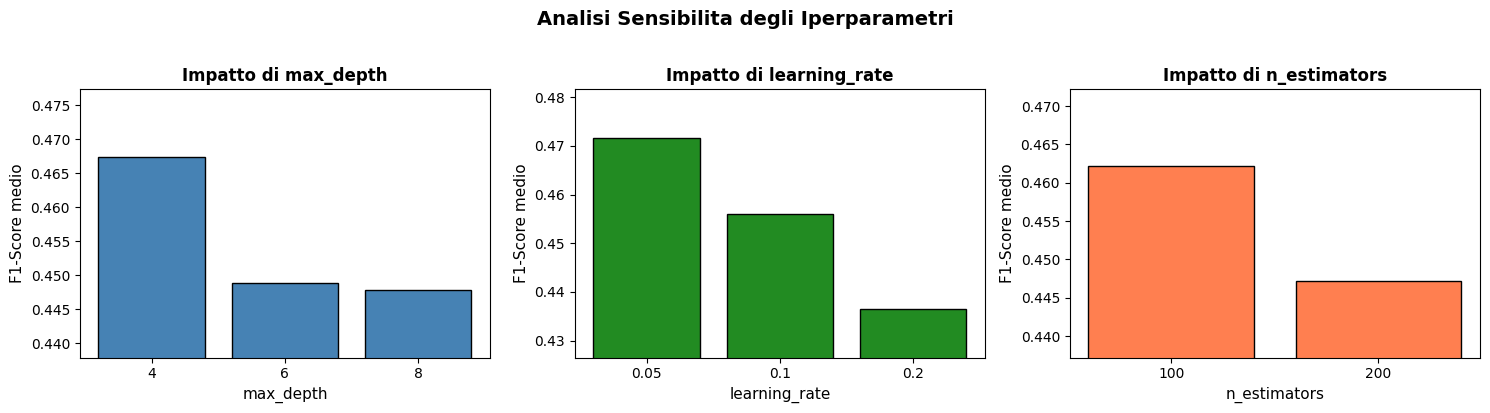


Osservazioni:
- max_depth ottimale: 4 (F1 = 0.4673)
- learning_rate ottimale: 0.05 (F1 = 0.4716)
- n_estimators ottimale: 100 (F1 = 0.4622)


In [ ]:

# Visualizzazione dell'impatto degli iperparametri
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Impatto di max_depth
depth_scores = results_df.groupby('param_max_depth')['mean_test_score'].mean()
axes[0].bar(depth_scores.index.astype(str), depth_scores.values, color='steelblue', edgecolor='black')
axes[0].set_xlabel('max_depth', fontsize=11)
axes[0].set_ylabel('F1-Score medio', fontsize=11)
axes[0].set_title('Impatto di max_depth', fontsize=12, fontweight='bold')
axes[0].set_ylim(depth_scores.min() - 0.01, depth_scores.max() + 0.01)

# 2. Impatto di learning_rate
lr_scores = results_df.groupby('param_learning_rate')['mean_test_score'].mean()
axes[1].bar(lr_scores.index.astype(str), lr_scores.values, color='forestgreen', edgecolor='black')
axes[1].set_xlabel('learning_rate', fontsize=11)
axes[1].set_ylabel('F1-Score medio', fontsize=11)
axes[1].set_title('Impatto di learning_rate', fontsize=12, fontweight='bold')
axes[1].set_ylim(lr_scores.min() - 0.01, lr_scores.max() + 0.01)

# 3. Impatto di n_estimators
nest_scores = results_df.groupby('param_n_estimators')['mean_test_score'].mean()
axes[2].bar(nest_scores.index.astype(str), nest_scores.values, color='coral', edgecolor='black')
axes[2].set_xlabel('n_estimators', fontsize=11)
axes[2].set_ylabel('F1-Score medio', fontsize=11)
axes[2].set_title('Impatto di n_estimators', fontsize=12, fontweight='bold')
axes[2].set_ylim(nest_scores.min() - 0.01, nest_scores.max() + 0.01)

plt.suptitle('Analisi Sensibilita degli Iperparametri', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\nOsservazioni:")
print(f"- max_depth ottimale: {depth_scores.idxmax()} (F1 = {depth_scores.max():.4f})")
print(f"- learning_rate ottimale: {lr_scores.idxmax()} (F1 = {lr_scores.max():.4f})")
print(f"- n_estimators ottimale: {nest_scores.idxmax()} (F1 = {nest_scores.max():.4f})")

In [ ]:
# Confronto xGBoost: Default vs Ottimizzato
# Valutiamo le performance sul test set per entrambe le versioni

# Modello con parametri di default (gia addestrato nella sezione precedente)
xgb_default = models['XGBoost']
xgb_default.fit(x_train_processed, y_train)
y_pred_default = xgb_default.predict(x_test_processed)
y_proba_default = xgb_default.predict_proba(x_test_processed)[:, 1]

# Modello ottimizzato (best_estimator_ di GridSearchCV)
xgb_tuned = grid_search_xgb.best_estimator_
y_pred_tuned = xgb_tuned.predict(x_test_processed)
y_proba_tuned = xgb_tuned.predict_proba(x_test_processed)[:, 1]

# Calcolo metriche
metrics_default = {
    'Accuracy': accuracy_score(y_test, y_pred_default),
    'Precision': precision_score(y_test, y_pred_default),
    'Recall': recall_score(y_test, y_pred_default),
    'F1-Score': f1_score(y_test, y_pred_default),
    'AUC-ROC': roc_auc_score(y_test, y_proba_default)
}

metrics_tuned = {
    'Accuracy': accuracy_score(y_test, y_pred_tuned),
    'Precision': precision_score(y_test, y_pred_tuned),
    'Recall': recall_score(y_test, y_pred_tuned),
    'F1-Score': f1_score(y_test, y_pred_tuned),
    'AUC-ROC': roc_auc_score(y_test, y_proba_tuned)
}

print("Confronto xGBoost: Default vs Ottimizzato (Test Set)")
print(f"\n{'Metrica':<15} {'Default':>12} {'Ottimizzato':>12} {'Differenza':>12}")

for metric in metrics_default.keys():
    val_default = metrics_default[metric]
    val_tuned = metrics_tuned[metric]
    diff = val_tuned - val_default
    sign = '+' if diff >= 0 else ''
    print(f"{metric:<15} {val_default:>12.4f} {val_tuned:>12.4f} {sign}{diff:>11.4f}")


Confronto xGBoost: Default vs Ottimizzato (Test Set)

Metrica              Default  Ottimizzato   Differenza
Accuracy              0.7360       0.7407 +     0.0047
Precision             0.4587       0.4752 +     0.0165
Recall                0.4808       0.6442 +     0.1635
F1-Score              0.4695       0.5469 +     0.0775
AUC-ROC               0.7347       0.7641 +     0.0294


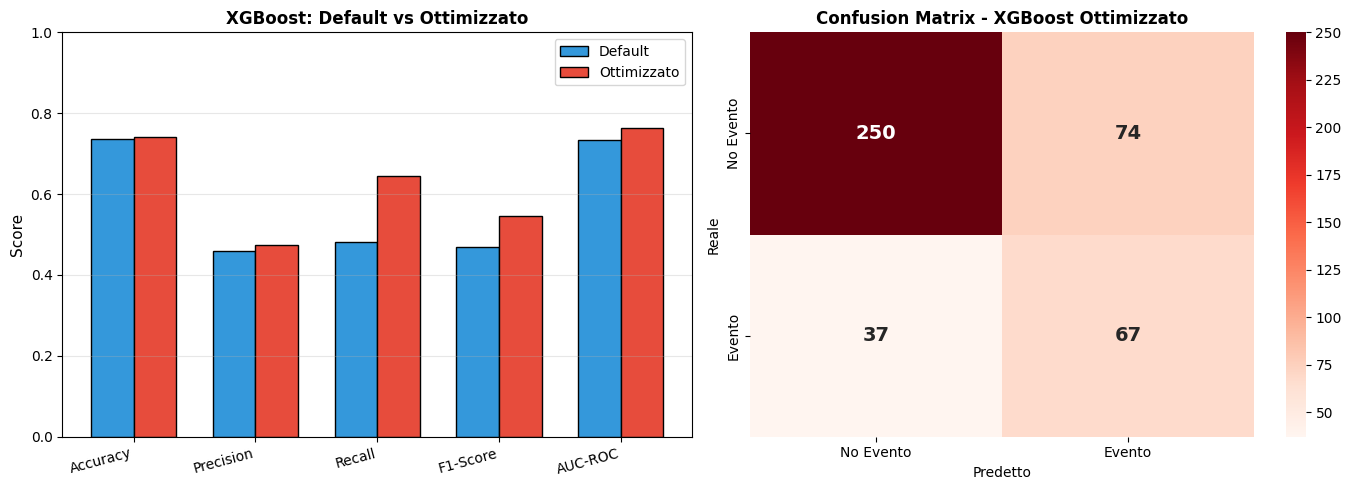

In [ ]:
# Visualizzazione del confronto
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Grafico 1: Confronto metriche
metrics_names = list(metrics_default.keys())
x = np.arange(len(metrics_names))
width = 0.35

bars1 = axes[0].bar(x - width/2, list(metrics_default.values()), width,
                    label='Default', color='#3498db', edgecolor='black')
bars2 = axes[0].bar(x + width/2, list(metrics_tuned.values()), width,
                    label='Ottimizzato', color='#e74c3c', edgecolor='black')

axes[0].set_ylabel('Score', fontsize=11)
axes[0].set_title('XGBoost: Default vs Ottimizzato', fontsize=12, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics_names, rotation=15, ha='right')
axes[0].legend()
axes[0].set_ylim(0, 1)
axes[0].grid(True, alpha=0.3, axis='y')

# Grafico 2: Confusion Matrix del modello ottimizzato
cm_tuned = confusion_matrix(y_test, y_pred_tuned)
sns.heatmap(
    cm_tuned,
    annot=True,
    fmt='d',
    cmap='Reds',
    ax=axes[1],
    xticklabels=['No Evento', 'Evento'],
    yticklabels=['No Evento', 'Evento'],
    annot_kws={'size': 14, 'weight': 'bold'}
)
axes[1].set_title('Confusion Matrix - XGBoost Ottimizzato', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Predetto', fontsize=10)
axes[1].set_ylabel('Reale', fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
# Sostituiamo XGBoost con la versione ottimizzata per le analisi successive

models['XGBoost'] = grid_search_xgb.best_estimator_

print("Modelli aggiornati:")
print("-"*40)
for name in models.keys():
    if name == 'XGBoost':
        print(f"  - {name} (ottimizzato con GridSearchCV)")
    else:
        print(f"  - {name}")

Modelli aggiornati:
----------------------------------------
  - Dummy (Baseline)
  - Logistic Regression
  - Gaussian Naive Bayes
  - Random Forest
  - XGBoost (ottimizzato con GridSearchCV)


# **Valutazione e confronto dei modelli**

In [ ]:
# Addestriamo tutti i modelli su tutto il training set e valutiamo le performance sul test set (dati mai visti durante il training).

final_results = {}

print("Training Finale e Valutazione su Test Set")
print("="*80)

for name, model in models.items():
    print(f"\n{name}:")

    # Training su tutto il training set
    # Nota: XGBoost e' gia stato addestrato da GridSearchCV
    if name != 'XGBoost':
        model.fit(x_train_processed, y_train)

    # Predizioni sul test set
    y_pred = model.predict(x_test_processed)

    # Probabilita per ROC-AUC (se il modello le supporta)
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(x_test_processed)[:, 1]
    else:
        y_pred_proba = None

    # Calcolo delle metriche
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else 0.5
    }

    # Salviamo tutto per analisi successive
    final_results[name] = {
        'metrics': metrics,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'model': model
    }

    print(f"  Accuracy: {metrics['accuracy']:.4f} | Precision: {metrics['precision']:.4f} | "
          f"Recall: {metrics['recall']:.4f} | F1: {metrics['f1']:.4f} | AUC: {metrics['roc_auc']:.4f}")

Training Finale e Valutazione su Test Set

Dummy (Baseline):
  Accuracy: 0.7570 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000 | AUC: 0.5000

Logistic Regression:
  Accuracy: 0.7009 | Precision: 0.4326 | Recall: 0.7404 | F1: 0.5461 | AUC: 0.7809

Gaussian Naive Bayes:
  Accuracy: 0.7617 | Precision: 0.5100 | Recall: 0.4904 | F1: 0.5000 | AUC: 0.7619

Random Forest:
  Accuracy: 0.7710 | Precision: 0.5333 | Recall: 0.4615 | F1: 0.4948 | AUC: 0.7564

XGBoost:
  Accuracy: 0.7407 | Precision: 0.4752 | Recall: 0.6442 | F1: 0.5469 | AUC: 0.7641


In [ ]:
#Tabella comparativa finale

print("Tabella Comparativa Finale (Test Set)")
print("="*85 + "\n")

final_df = pd.DataFrame()
for name in models.keys():
    m = final_results[name]['metrics']
    row = {
        'Modello': name,
        'Accuracy': f"{m['accuracy']:.4f}",
        'Precision': f"{m['precision']:.4f}",
        'Recall': f"{m['recall']:.4f}",
        'F1-Score': f"{m['f1']:.4f}",
        'AUC-ROC': f"{m['roc_auc']:.4f}"
    }
    final_df = pd.concat([final_df, pd.DataFrame([row])], ignore_index=True)

print(final_df.to_string(index=False))

# Identifichiamo il miglior modello basandoci sull'F1-Score
best_model_name = max(
    final_results.keys(),
    key=lambda x: final_results[x]['metrics']['f1']
)
best_f1 = final_results[best_model_name]['metrics']['f1']

print(f"\nMiglior modello (per F1-Score): {best_model_name}")
print(f"F1-Score: {best_f1:.4f}")

Tabella Comparativa Finale (Test Set)

             Modello Accuracy Precision Recall F1-Score AUC-ROC
    Dummy (Baseline)   0.7570    0.0000 0.0000   0.0000  0.5000
 Logistic Regression   0.7009    0.4326 0.7404   0.5461  0.7809
Gaussian Naive Bayes   0.7617    0.5100 0.4904   0.5000  0.7619
       Random Forest   0.7710    0.5333 0.4615   0.4948  0.7564
             XGBoost   0.7407    0.4752 0.6442   0.5469  0.7641

Miglior modello (per F1-Score): XGBoost
F1-Score: 0.5469


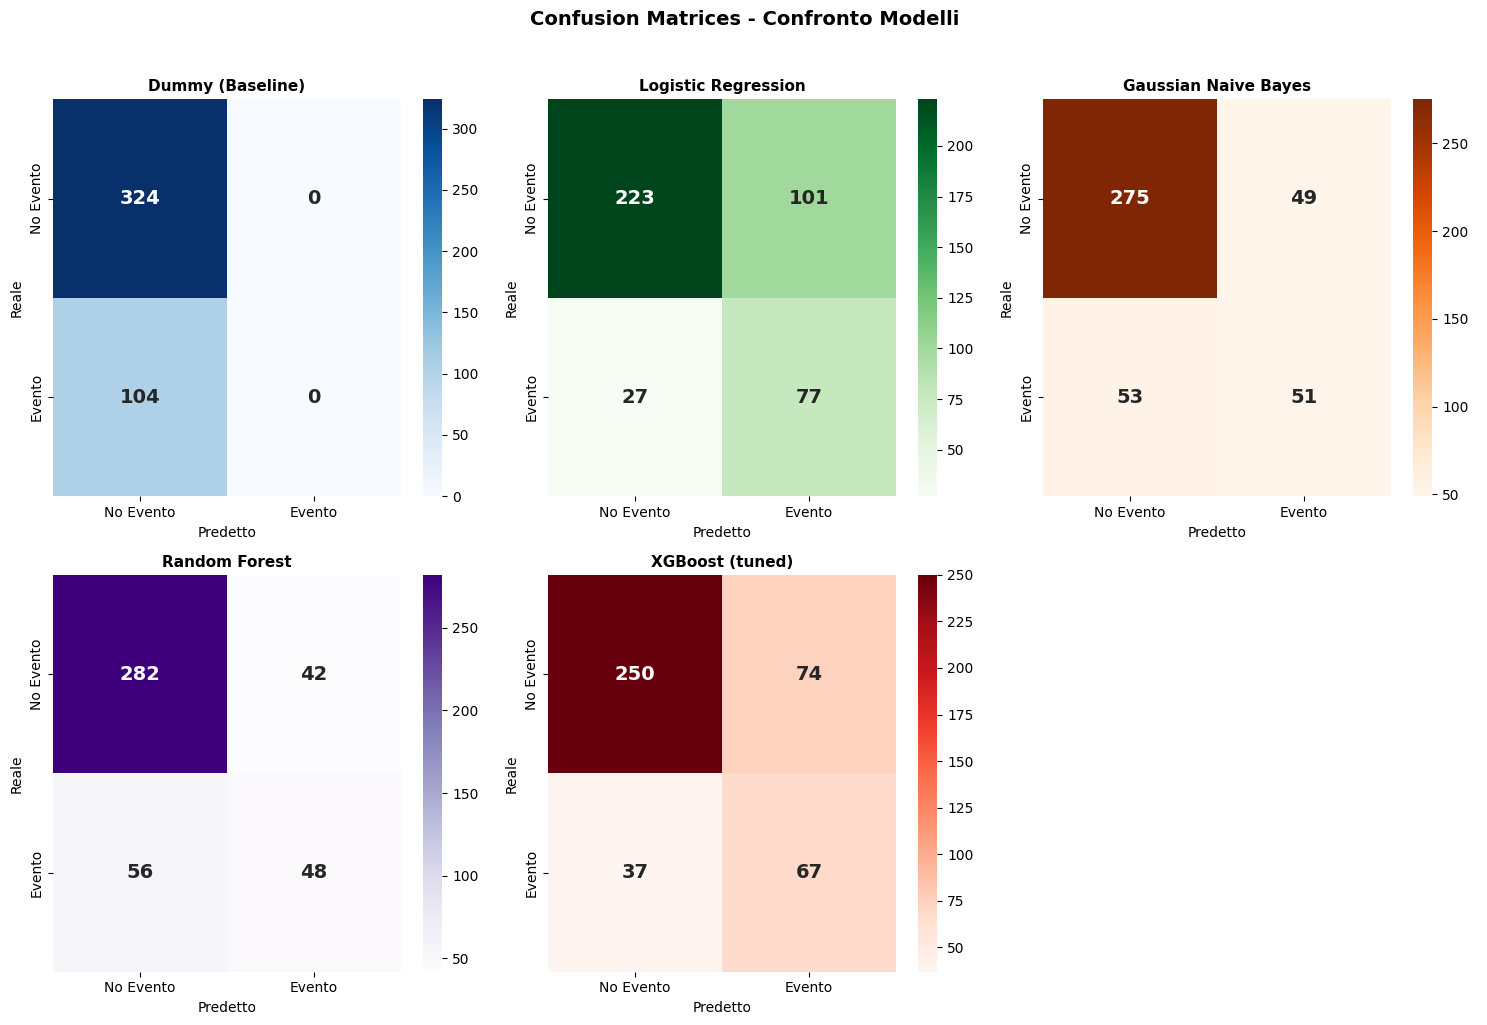

In [ ]:
# Confusion Matrices per tutti i modelli

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

model_names = list(models.keys())
cmap_colors = ['Blues', 'Greens', 'Oranges', 'Purples', 'Reds']

for i, name in enumerate(model_names):
    cm = confusion_matrix(y_test, final_results[name]['y_pred'])

    ax = axes[i]
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap=cmap_colors[i],
        ax=ax,
        xticklabels=['No Evento', 'Evento'],
        yticklabels=['No Evento', 'Evento'],
        annot_kws={'size': 14, 'weight': 'bold'}
    )

    # Aggiungiamo nota se ottimizzato
    title = name
    if name == 'XGBoost':
        title += ' (tuned)'
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.set_xlabel('Predetto', fontsize=10)
    ax.set_ylabel('Reale', fontsize=10)

# Nascondiamo l'ultimo subplot vuoto
axes[5].axis('off')

plt.suptitle('Confusion Matrices - Confronto Modelli', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

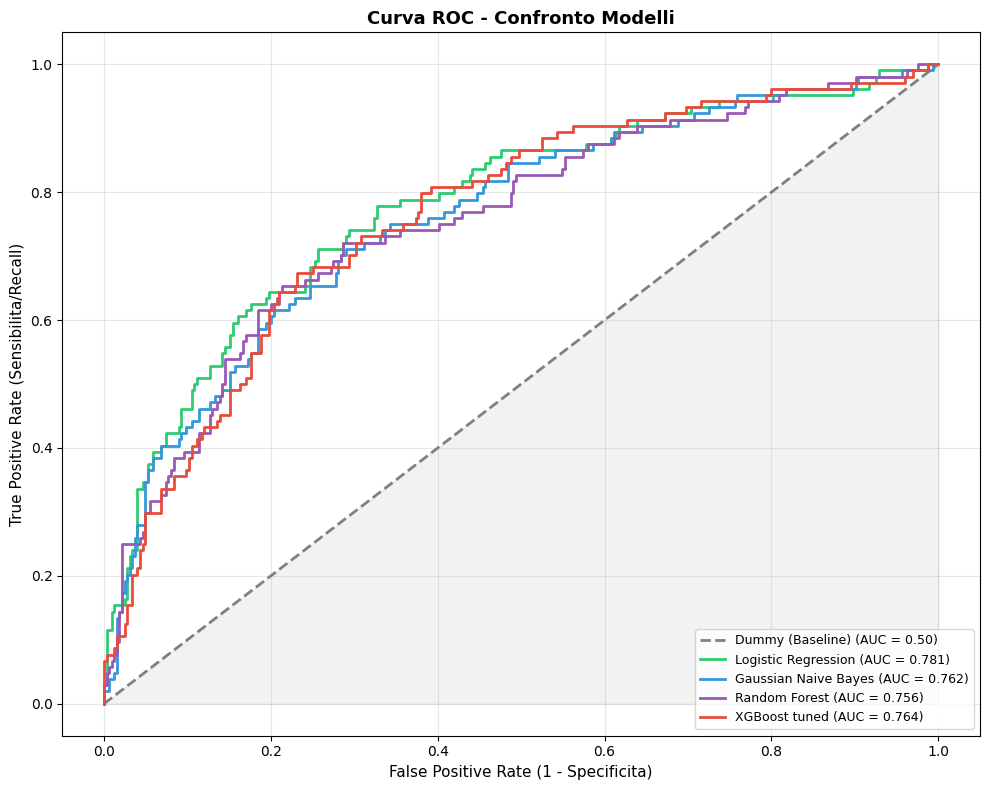

In [ ]:
# Curve ROC
fig, ax = plt.subplots(figsize=(10, 8))

colors = ['gray', '#2ecc71', '#3498db', '#9b59b6', '#e74c3c']

for i, name in enumerate(model_names):
    y_proba = final_results[name]['y_pred_proba']

    if name == 'Dummy (Baseline)':
        ax.plot([0, 1], [0, 1], color=colors[i], linestyle='--', linewidth=2,
                label=f'{name} (AUC = 0.50)')
    else:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = roc_auc_score(y_test, y_proba)
        label = f'{name} (AUC = {auc:.3f})'
        if name == 'XGBoost':
            label = f'{name} tuned (AUC = {auc:.3f})'
        ax.plot(fpr, tpr, color=colors[i], linewidth=2, label=label)

ax.set_xlabel('False Positive Rate (1 - Specificita)', fontsize=11)
ax.set_ylabel('True Positive Rate (Sensibilita/Recall)', fontsize=11)
ax.set_title('Curva ROC - Confronto Modelli', fontsize=13, fontweight='bold')
ax.legend(loc='lower right', fontsize=9)
ax.grid(True, alpha=0.3)
ax.fill_between([0, 1], [0, 1], alpha=0.1, color='gray')

plt.tight_layout()
plt.show()

In [ ]:
# Classification Report per il miglior modello

print(f"Classification Report - {best_model_name}")
print(classification_report(
    y_test,
    final_results[best_model_name]['y_pred'],
    target_names=['No Evento', 'Evento']
))

Classification Report - XGBoost
              precision    recall  f1-score   support

   No Evento       0.87      0.77      0.82       324
      Evento       0.48      0.64      0.55       104

    accuracy                           0.74       428
   macro avg       0.67      0.71      0.68       428
weighted avg       0.77      0.74      0.75       428



# **Interpretazione dei risultati**

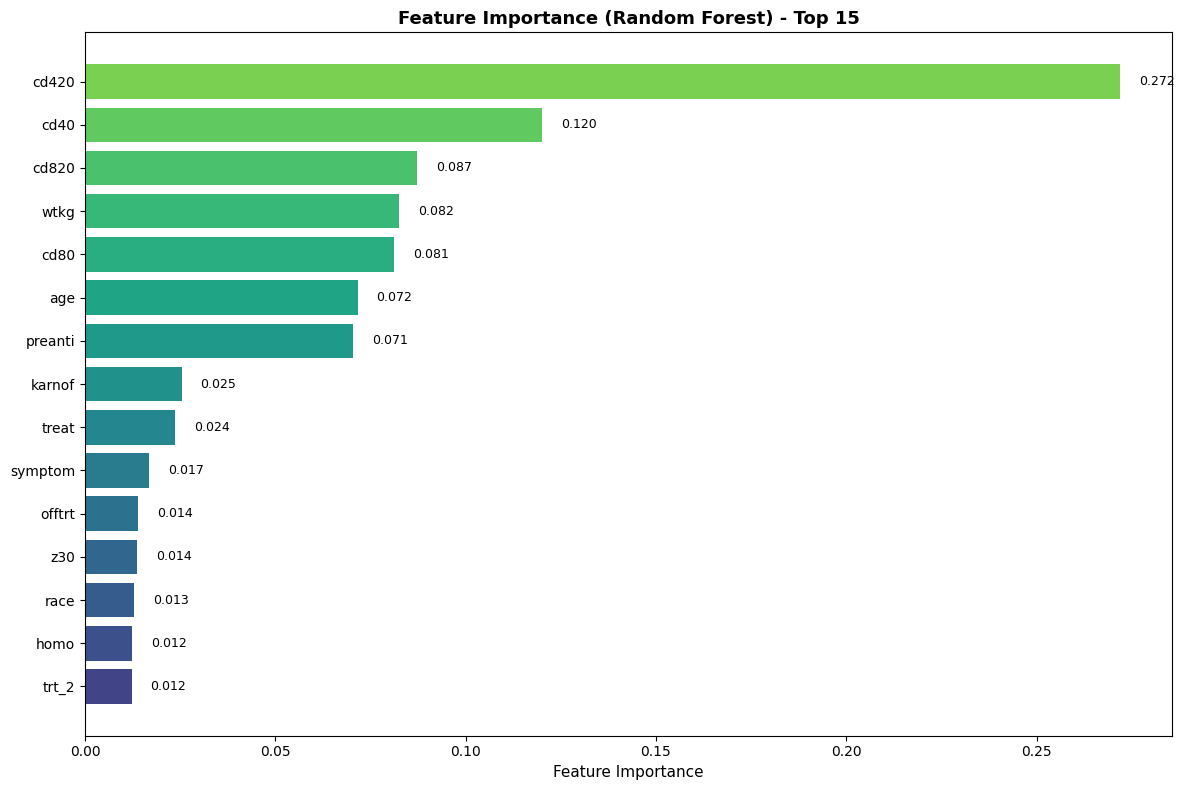

In [ ]:
# Il Random Forest ci fornisce una misura dell'importanza di ogni feature basata su quanto contribuisce alla riduzione dell'impurita nei nodi.

rf_model = final_results['Random Forest']['model']
rf_importances = rf_model.feature_importances_

# Ordiniamo per importanza decrescente
rf_indices = np.argsort(rf_importances)[::-1]

# Visualizziamo le top 15 feature
n_top = 15
top_indices = rf_indices[:n_top]

fig, ax = plt.subplots(figsize=(12, 8))

colors = plt.cm.viridis(np.linspace(0.8, 0.2, n_top))
bars = ax.barh(range(n_top), rf_importances[top_indices][::-1], color=colors[::-1])

ax.set_yticks(range(n_top))
ax.set_yticklabels([feature_names[i] for i in top_indices][::-1], fontsize=10)
ax.set_xlabel('Feature Importance', fontsize=11)
ax.set_title('Feature Importance (Random Forest) - Top 15', fontsize=13, fontweight='bold')

# Valori sulle barre
for bar, val in zip(bars, rf_importances[top_indices][::-1]):
    ax.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
            f'{val:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

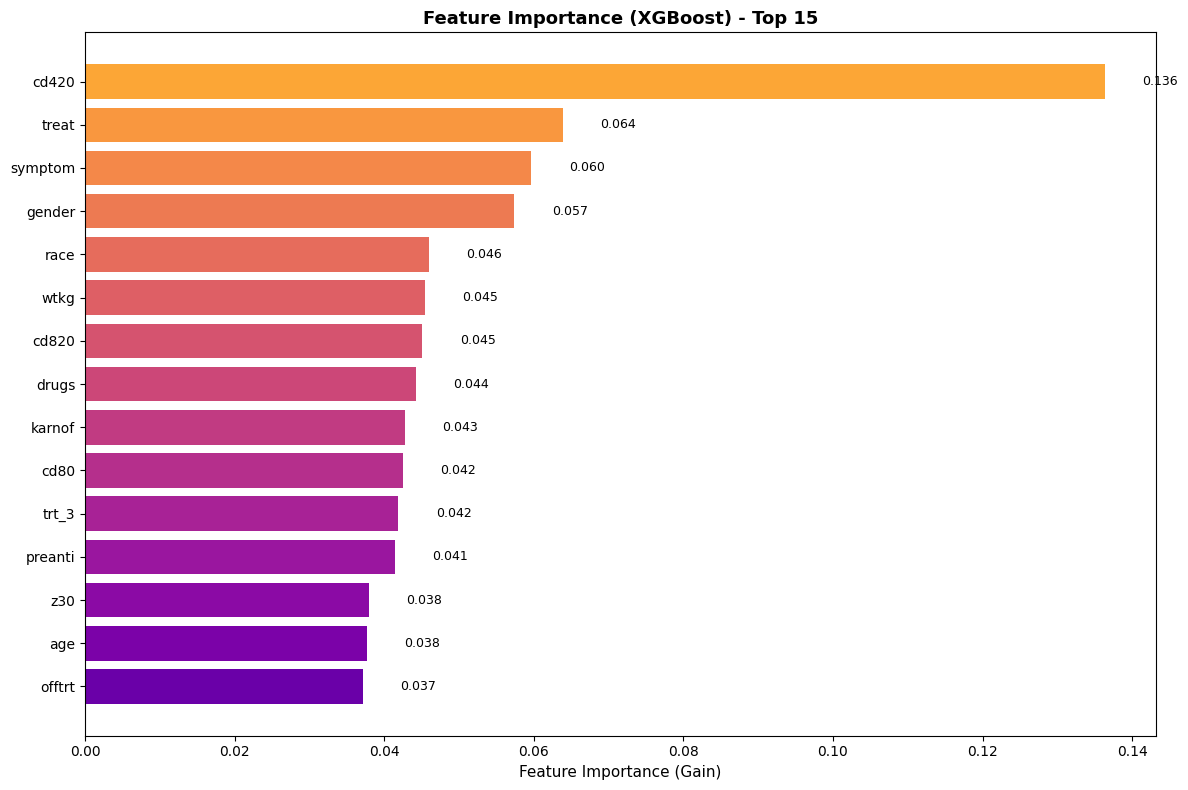


Top 10 Feature secondo XGBoost:
 1. cd420          : 0.1364
 2. treat          : 0.0639
 3. symptom        : 0.0597
 4. gender         : 0.0574
 5. race           : 0.0460
 6. wtkg           : 0.0454
 7. cd820          : 0.0451
 8. drugs          : 0.0442
 9. karnof         : 0.0427
10. cd80           : 0.0425


In [ ]:
# XGBoost calcola l'importanza basandosi sul "gain", ovvero quanto ognifeature contribuisce a migliorare la predizione quando viene usata per uno split.

xgb_model = final_results['XGBoost']['model']
xgb_importances = xgb_model.feature_importances_

# Ordiniamo per importanza decrescente
xgb_indices = np.argsort(xgb_importances)[::-1]
top_indices_xgb = xgb_indices[:n_top]

fig, ax = plt.subplots(figsize=(12, 8))

colors = plt.cm.plasma(np.linspace(0.8, 0.2, n_top))
bars = ax.barh(range(n_top), xgb_importances[top_indices_xgb][::-1], color=colors[::-1])

ax.set_yticks(range(n_top))
ax.set_yticklabels([feature_names[i] for i in top_indices_xgb][::-1], fontsize=10)
ax.set_xlabel('Feature Importance (Gain)', fontsize=11)
ax.set_title('Feature Importance (XGBoost) - Top 15', fontsize=13, fontweight='bold')

for bar, val in zip(bars, xgb_importances[top_indices_xgb][::-1]):
    ax.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
            f'{val:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

# Stampiamo le top 10 feature
print("\nTop 10 Feature secondo XGBoost:")
for i, idx in enumerate(top_indices_xgb[:10], 1):
    print(f"{i:2}. {feature_names[idx]:<15}: {xgb_importances[idx]:.4f}")

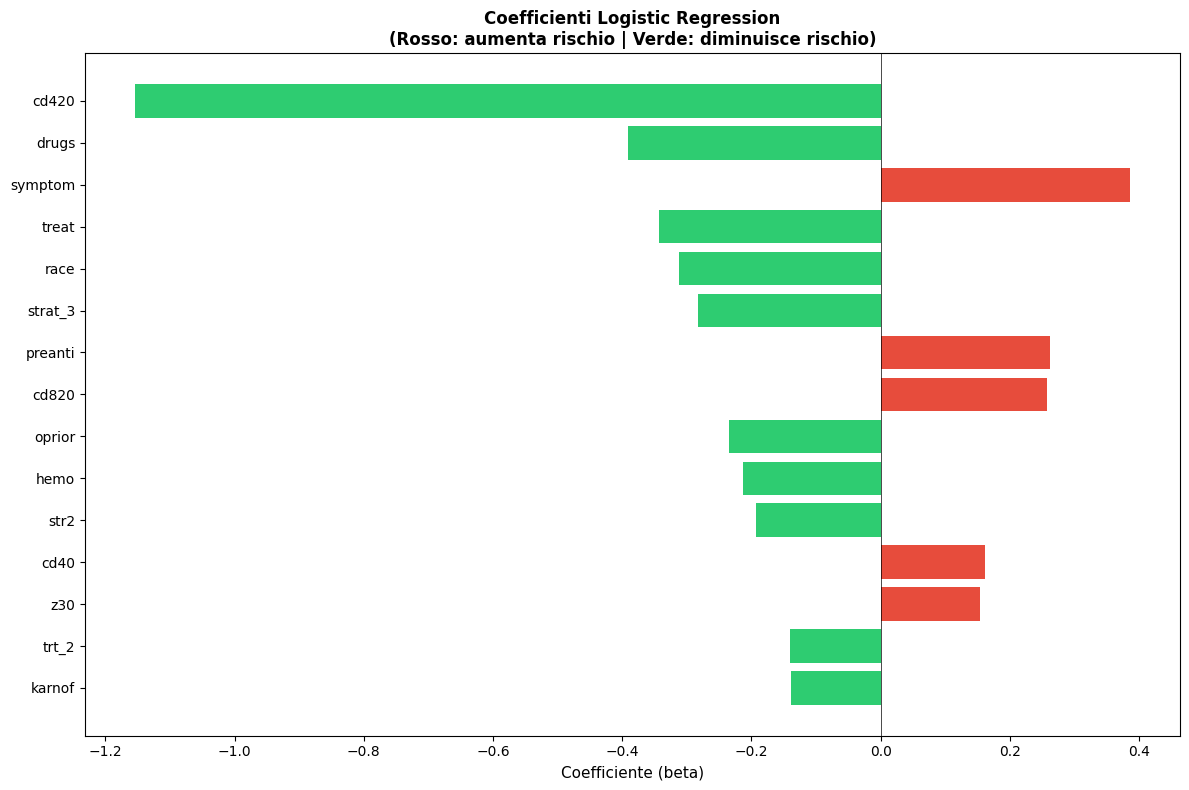


Interpretazione dei coefficienti:
Un coefficiente positivo indica che valori alti della feature
sono associati a maggiore probabilita' di evento (rischio).

Un coefficiente negativo indica un effetto protettivo.


In [ ]:
# Coefficienti della Logistic Regression

lr_model = final_results['Logistic Regression']['model']
coefficients = lr_model.coef_[0]

# Ordiniamo per valore assoluto
indices = np.argsort(np.abs(coefficients))[::-1]
top_indices_lr = indices[:n_top]

fig, ax = plt.subplots(figsize=(12, 8))

# Colori basati sul segno del coefficiente
colors = ['#e74c3c' if coefficients[i] > 0 else '#2ecc71' for i in top_indices_lr][::-1]

bars = ax.barh(range(n_top), coefficients[top_indices_lr][::-1], color=colors)

ax.set_yticks(range(n_top))
ax.set_yticklabels([feature_names[i] for i in top_indices_lr][::-1], fontsize=10)
ax.set_xlabel('Coefficiente (beta)', fontsize=11)
ax.set_title('Coefficienti Logistic Regression\n(Rosso: aumenta rischio | Verde: diminuisce rischio)',
             fontsize=12, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()